In [58]:
# Okay, let's have a look at what the oscillator networks are doing
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils
import copy
import os
from datetime import datetime

%load_ext autoreload
%autoreload 2

# Set up our parameters
path_here = %pwd
folder = "23_08_30_163105"
name = 'best_model'
path_name = path_here + "/" + folder + "/" + name
model = torch.load(path_name)

device = 'cpu'
params = torch.load(path_here + '/' + folder + '/' + 'params')
print(params.model.h_size)
print(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100
{'data': {'data_type': 0, 'min_length': 200, 'max_length': 1000, 'batch_size': 5, 'min_beats': 3, 'max_beats': 6, 'freq_type': 1, 'jitter_type': 1, 'min_freq': 9, 'max_freq': 10, 'freqs': [4, 5, 6, 7, 9, 10, 11, 12], 'offset': 1, 'oscillators': 1}, 'model': {'h_size': 100, 'hidden_act': 'relu', 'hidden_init_learn': True, 'hidden_init_std': 1, 'transition_init': 'orthogonal', 'output_act': 'sigmoid', 'i_size': 1, 't_size': 1, 'linear_std': 1, 'batch_size': 8, 'num_inits': 8}, 'train': {'learning_rate': 5e-05, 'weight_decay': 0.001, 'train_iters': 100000, 'act_weight': 0.01, 'save_iters': 10000, 'print_iters': 100, 'use_existing_model': 0}}


In [60]:
path_name

'/nfs/nhome/live/wdorrell/Periodic_RNNs/Periodic_RNNs/James_Network/23_08_30_163105/best_model'

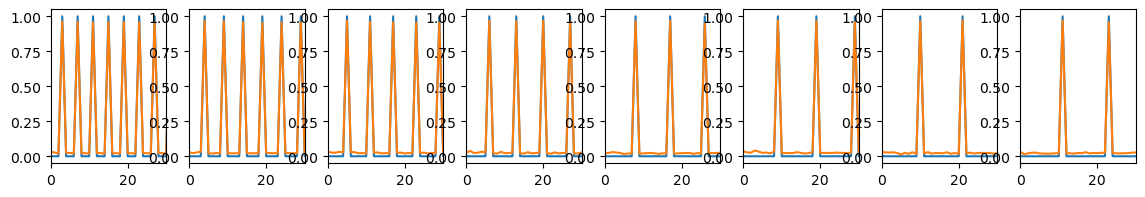

In [ ]:
# Let's extract all the weights, biases, and the activities on a big set of frequencies
T = 300
xlimit = 30
params.data.min_length = T
params.data.max_length = T+1
input_dict = utils.generate_osc_data(params)

# Weights and biases
hidden_init = model.hidden_init.detach().numpy()
out_weights = model.predict.state_dict()['weight'][0,:].detach().numpy()
out_bias = model.predict.state_dict()['bias'].detach().numpy()
hidden_weights = model.transition.state_dict()['weight'].detach().numpy()
hidden_biases = model.transition.state_dict()['bias'].detach().numpy()

variables = model(input_dict, device=device)
output = torch.stack(variables.pred).detach().numpy()[:,:,0]
hidden = torch.stack(variables.hidden).detach().numpy()
pres = torch.stack(variables.pres).detach().numpy()

plt.figure(figsize=(14,2))
for sample in range(params.model.batch_size):
    plt.subplot(1,params.model.batch_size,1+sample)
    #plt.title(f'Desired Function, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample],label='target')
    plt.plot(output[:,sample])
    #plt.legend()
    plt.xlim([0, xlimit])

([], [])

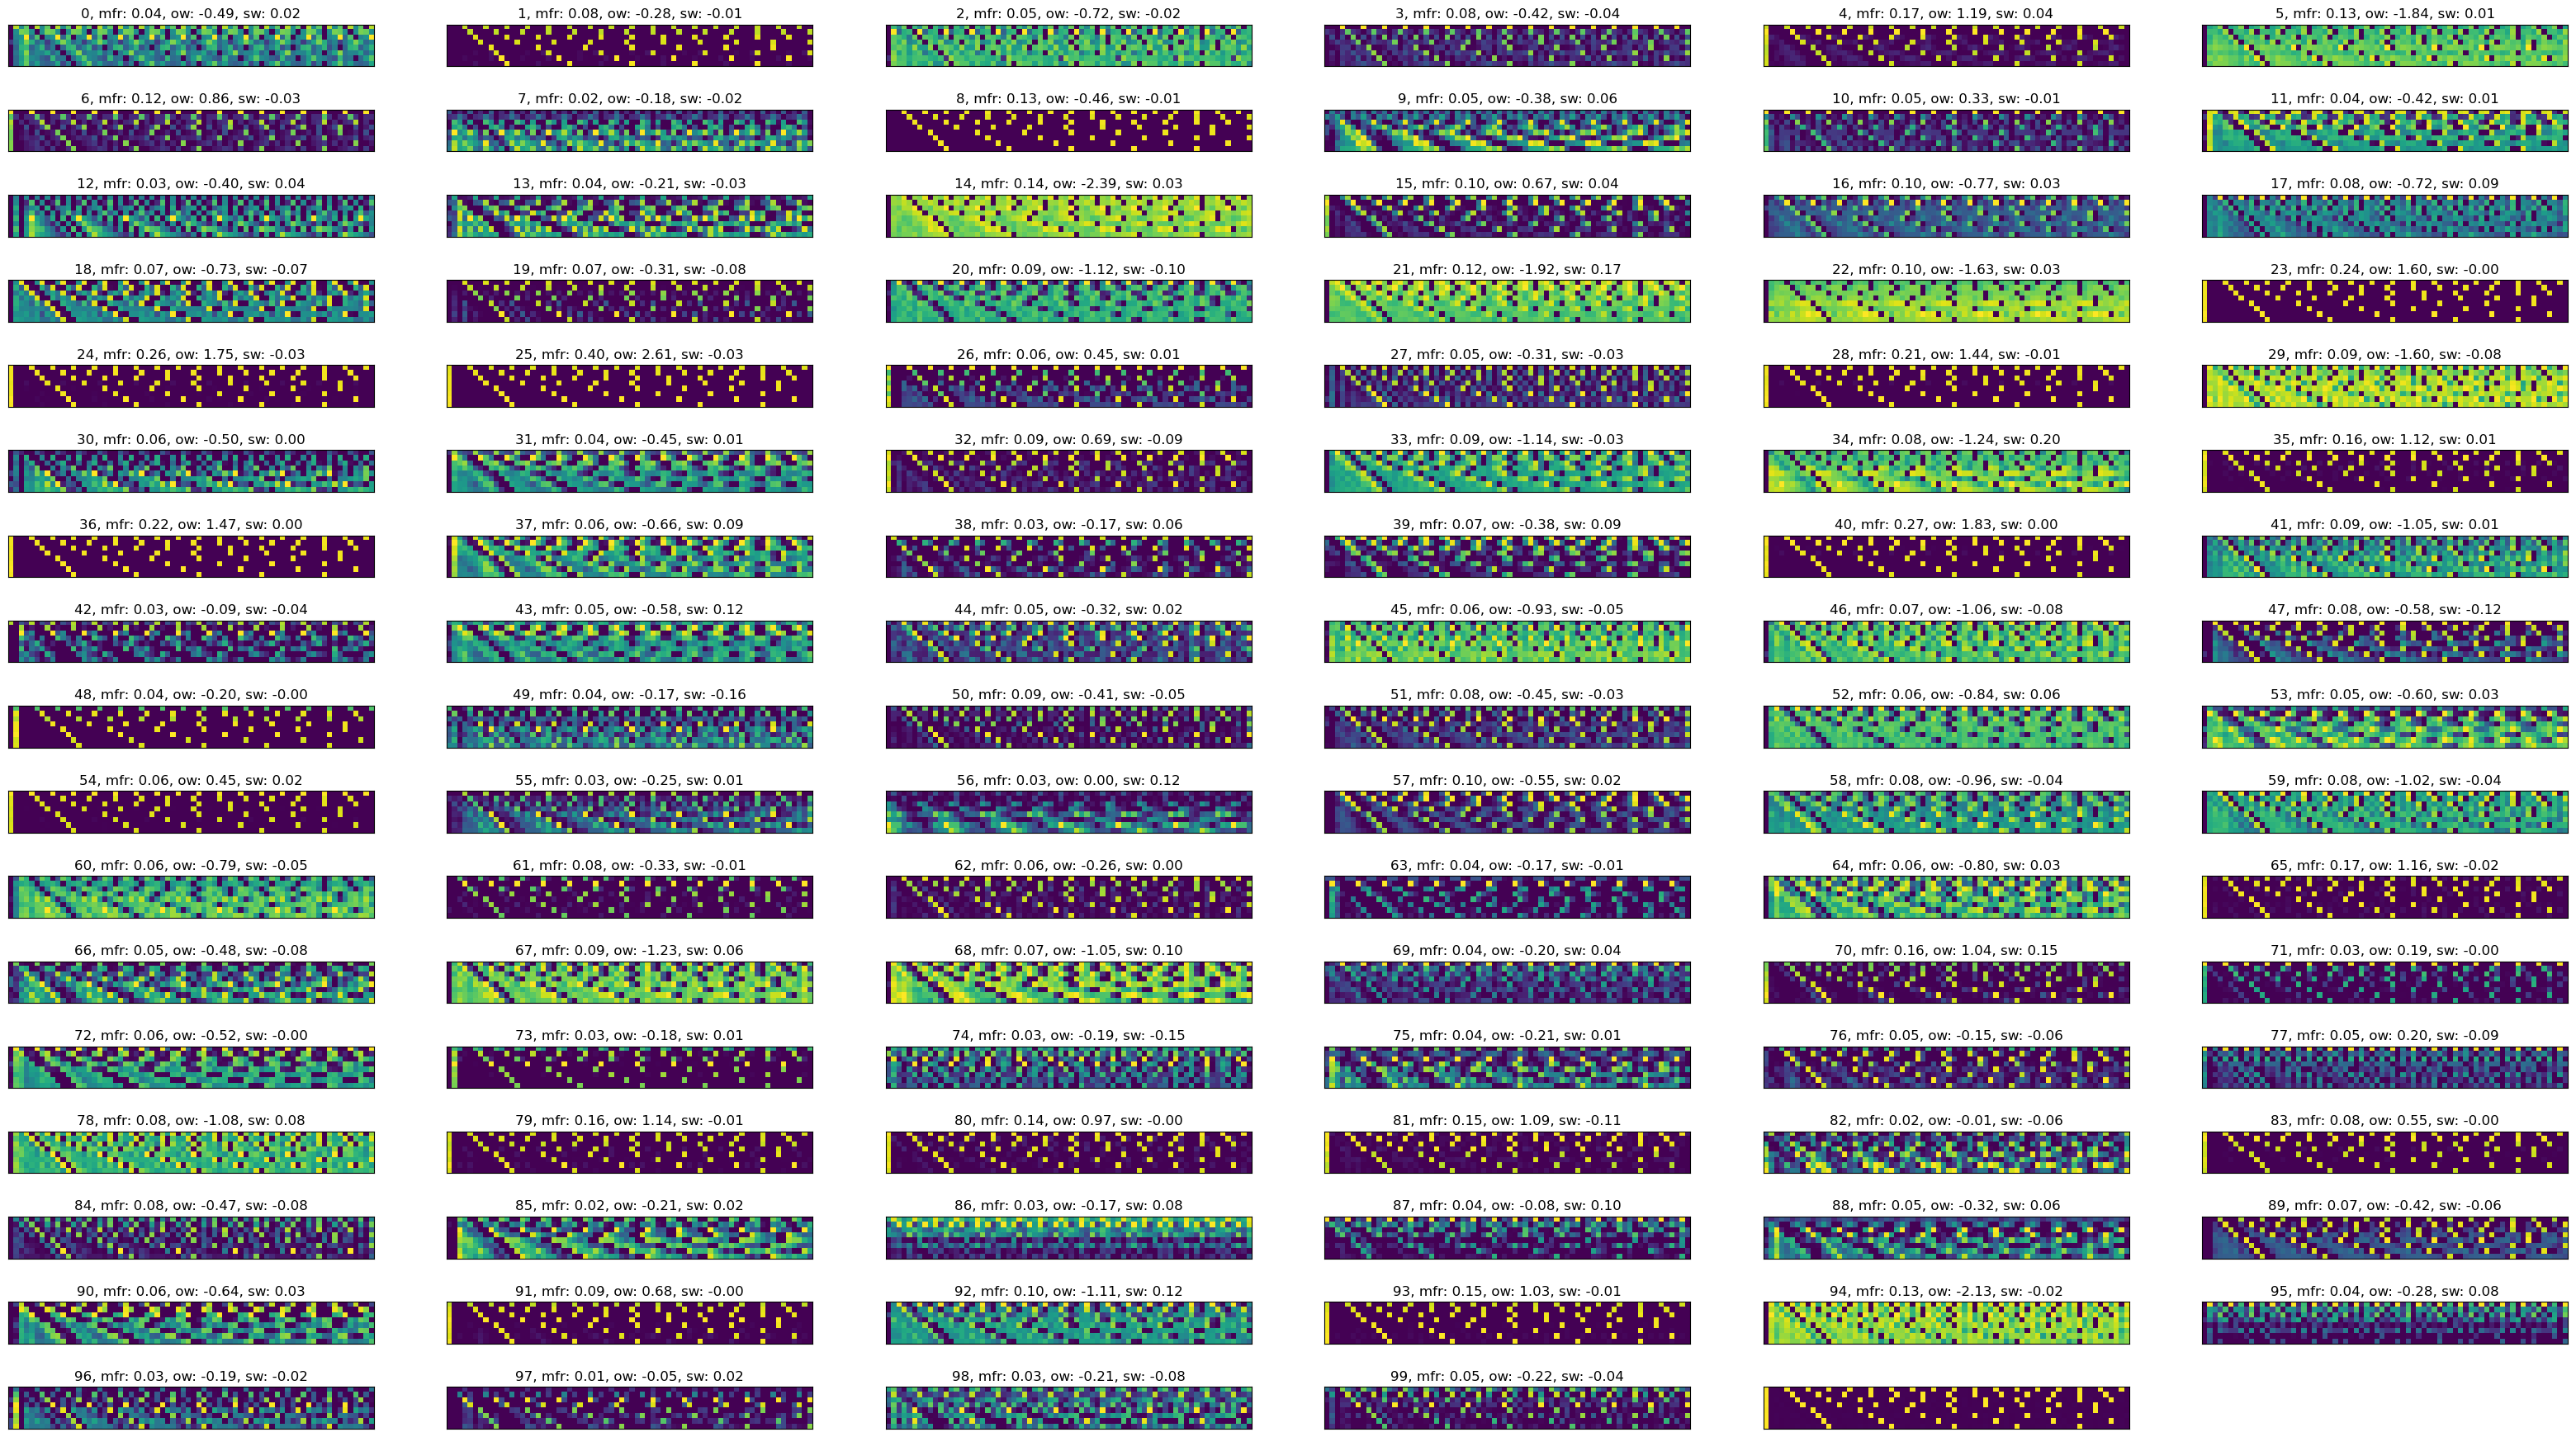

In [7]:
targets = input_dict.outputs.detach().numpy()
target_time = 200
time_length = 70
freqs = params.data.freqs

hid = np.zeros([time_length, len(freqs), model.par.h_size])
out = np.zeros([time_length, len(freqs)])
for (freq_ind, freq) in enumerate(freqs):
    out_spike_times = np.where(targets[:,freq_ind] != 0)[0]
    start_time = out_spike_times[np.argmin(np.abs(out_spike_times - target_time))]
    
    hid[:,freq_ind] = hidden[start_time:start_time+time_length,freq_ind,:]
    out[:,freq_ind] = output[start_time:start_time+time_length,freq_ind]
    
columns = 6
rows = int(np.ceil((model.par.h_size+1)/3))
plt.figure(figsize = (40,rows*len(freqs)/6))
for neuron in range(model.par.h_size):
    plt.subplot(rows, columns, neuron+1)
    plt.imshow(hid[:, :, neuron].T)
    plt.title(f'{neuron}, mfr: {np.max(hid[:, :, neuron]):.2f}, ow: {out_weights[neuron]:.2f}, sw: {hidden_weights[neuron, neuron]:.2f}')
    plt.xticks([])
    plt.yticks([])

plt.subplot(rows, columns, model.par.h_size+1)
plt.imshow(out.T)
plt.xticks([])
plt.yticks([])

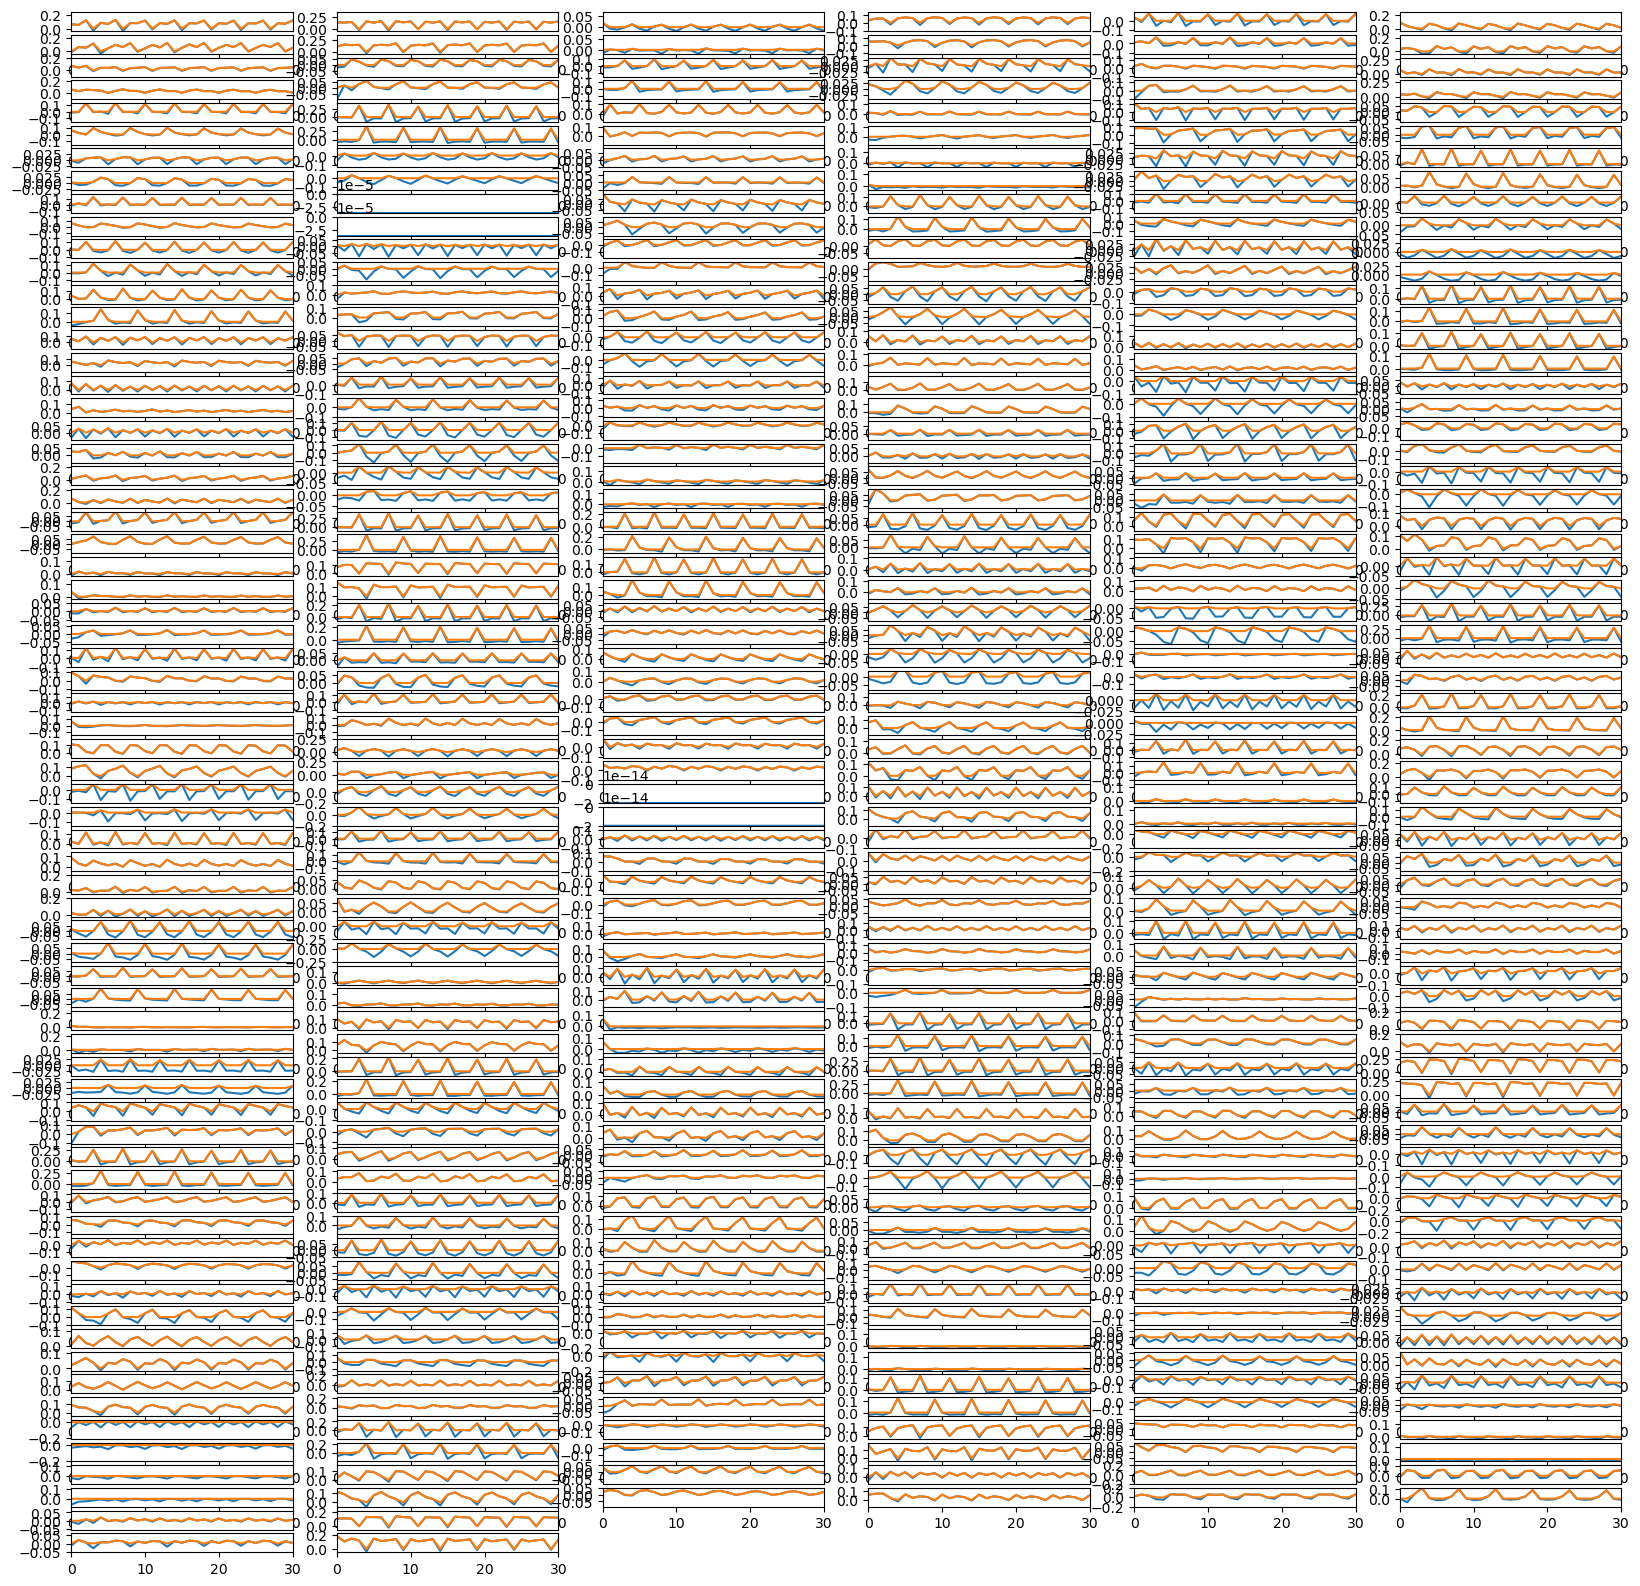

In [24]:
plt.figure(figsize = (20,20))
columns = 6
rows = int(np.ceil(2*params.model.h_size/columns))+1
counter = -1
for neuron in range(params.model.h_size):
    ylimit_max = np.amax(hidden[:,:,neuron])
    ylimit_min = np.amin(pres[:,:,neuron])
    
    pres_here = pres[:,:,neuron]
    #pres_here[pres_here > 0] = 0
    
    if neuron%columns == 0:
        counter += 1
    plt.subplot(rows, columns, neuron+1+counter*columns)
    plt.plot(pres_here[:,0])
    plt.plot(hidden[:,0,neuron])

    plt.xlim([0, xlimit])
    plt.ylim([ylimit_min, ylimit_max])
    plt.xticks([])

    plt.subplot(rows, columns, neuron+1+(counter+1)*columns)
    plt.plot(pres_here[:,1])
    plt.plot(hidden[:,1,neuron])
    plt.xlim([0, xlimit])
    plt.ylim([ylimit_min, ylimit_max])

(-0.023204408586025238, 0.11089488863945007)

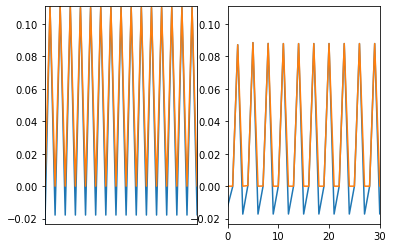

In [196]:
neuron = 17

ylimit_max = np.amax(hidden[:,:,neuron])
ylimit_min = np.amin(pres[:,:,neuron])
pres_here = pres[:,:,neuron]
#pres_here[pres_here > 0] = 0

if neuron%columns == 0:
    counter += 1
plt.subplot(1,2,1)
plt.plot(pres_here[:,0])
plt.plot(hidden[:,0,neuron])

plt.xlim([0, xlimit])
plt.ylim([ylimit_min, ylimit_max])
plt.xticks([])

plt.subplot(1,2,2)
plt.plot(pres_here[:,1])
plt.plot(hidden[:,1,neuron])
plt.xlim([0, xlimit])
plt.ylim([ylimit_min, ylimit_max])

In [11]:
# Here we try to train the initiliasation to do a frequency it has never seen before

In [43]:
for parameter in model.parameters():
    parameter.requires_grad = False

model.par.batch_size = 1
model.hidden_init = torch.nn.Parameter(torch.abs(torch.normal(0, 1, [1, model.par.h_size])))
model.hidden_init.requires_grad = True

params.data.freqs = [8]
params.data.max_length = 300

In [46]:
optimizer = optim.Adam(model.parameters(), lr=params.train.learning_rate, weight_decay=params.train.weight_decay)
min_loss = np.infty

# Setup save directory
path = os.getcwd()
now = datetime.now()
current_time = now.strftime("%y_%m_%d_%H%M%S")
directory = path + "/" + current_time + "/"
if not os.path.exists(directory):
    os.makedirs(directory)
torch.save(params, directory + 'params')

generator = utils.generate_osc_data
loss_func = _model_.compute_losses_torch

print('Starting Training')

for train_i in range(params.train.train_iters):

    # 1. Get input data, and convert to tensors (I have assumed you will put inputs etc into a dictionary)
    input_dict = generator(params)#, freqs = np.full(params.data.batch_size, 7, dtype=int))
    
    # set all gradients to None
    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
        
    # forward pass
    variables = model(input_dict, device=device)
    
    # collate inputs for model
    (losses, loss_fit) = loss_func(input_dict, variables, model, params.train, device=device)

    # backward pass
    losses.backward()

    # clip gradients (you don't have to do this but it's a good idea for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)

    optimizer.step()
    
    if losses.detach() < min_loss:
        min_loss = losses.detach()
        best_model = model
        print(f"{train_i}, new PB! {min_loss}")
        torch.save(best_model, directory + 'best_model')

    if train_i % params.train.print_iters == 0:
        print(f"{train_i}, {losses.item():.5f}, {loss_fit.item():.5f}, {losses.item()-loss_fit.item():.5f}")
        
    if train_i % params.train.save_iters == 0:
        model_name = directory + str(train_i)
        torch.save(model, model_name)

Starting Training
0, new PB! 82.35285552587145
0, 82.35286, 80.71892, 1.63393
2, new PB! 72.85380065400099
3, new PB! 71.88046867063022
5, new PB! 71.77974114825037
11, new PB! 71.2228389045947
13, new PB! 64.35599806826457
19, new PB! 41.80140772188139
22, new PB! 40.40909030805261
25, new PB! 35.82243217836076
28, new PB! 35.32604279527543
33, new PB! 34.0437105301516
49, new PB! 33.722010632762085
53, new PB! 33.54372400369925
69, new PB! 33.16471950372788
80, new PB! 32.82002246355405
82, new PB! 32.72859082248969
100, 34.84183, 33.59917, 1.24266
101, new PB! 32.22986466056176
108, new PB! 32.06041025061937
117, new PB! 31.994590200847277
119, new PB! 31.896426992177354
129, new PB! 31.86882327209397
193, new PB! 31.638471900509867
198, new PB! 31.631384338274067
200, 39.61239, 38.34842, 1.26397
258, new PB! 31.59386791674352
300, 35.19421, 33.95884, 1.23537
353, new PB! 31.578527226644297
400, 36.01597, 34.77548, 1.24049
430, new PB! 31.574490033076707
462, new PB! 31.555707252067


KeyboardInterrupt

